<div style="width:100%;text-align: top;"> <img align=middle src="https://mmo.aiircdn.com/141/5ed59862e602f.png" alt="Heat beating" style="height:400px;margin-top:1rem;"> </div>

## BUILDING ENERGY CONSUMPTION ANALYSIS

Climate change is a global challenge and carbon pollution knows no boundaries.<br>
In 2011, Seattle adopted the goal to become carbon neutral by 2050. The overall approach to carbon reductions in the buildings is to provide information, financial and other incentives, and technical assistance, while establishing strong standards for efficiency and emissions. <br>
As part of the City of Seattle, our team will focus on Green House Gas Emissions from non residential buildings.<br>
Our final objective is to predict CO2 emissions and the Total Energy Use for buildings that do not have yet any measurements.  <br>
To achieve this

In [149]:
#! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import numpy as np                # numerical data processing
import pandas as pd               # numerical tables & time series
import scipy as sp                # numerical integration, interpolation, optimization, linear algebra, and statistics
import scipy.stats as st          # statistical functions
import seaborn as sns             # statistical data visualization
import matplotlib.pyplot as plt   # static, animated, and interactive visualizations in Python
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from IPython.display import HTML



In [150]:
# Transforming our input files.csv from the cleaning phase to dataframe

df_data = pd.read_csv("data_cleaned.csv")
df_data = df_data.drop(['Unnamed: 0'], axis=1)
df_data.head(2)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,...,Longitude,Address,City,State,ZipCode,AgeofBuilding,MeanBuildingGFA,MeanFloorGFA,BuildingGFApct,ParkingGFApct
0,1,2015,NonResidential,Hotel,Mayflower Park Hotel,Downtown,1.0,12.0,88434,Hotel,...,-122.337997,405 Olive Way,Seattle,WA,98101.0,88,88434.0,7369.5,1.0,0.0
1,1,2016,NonResidential,Hotel,Mayflower Park Hotel,Downtown,1.0,12.0,88434,Hotel,...,-122.337990,405 Olive Way,Seattle,WA,98101.0,89,88434.0,7369.5,1.0,0.0


In [151]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3173 non-null   int64  
 1   DataYear                      3173 non-null   int64  
 2   BuildingType                  3173 non-null   object 
 3   PrimaryPropertyType           3173 non-null   object 
 4   PropertyName                  3173 non-null   object 
 5   Neighborhood                  3173 non-null   object 
 6   NumberofBuildings             3173 non-null   float64
 7   NumberofFloors                3173 non-null   float64
 8   PropertyGFATotal              3173 non-null   int64  
 9   LargestPropertyUseType        3104 non-null   object 
 10  YearsENERGYSTARCertified      183 non-null    object 
 11  ENERGYSTARScore               2104 non-null   float64
 12  SiteEnergyUse(kBtu)           3173 non-null   float64
 13  GHG

In [152]:
non_reg = ['YearsENERGYSTARCertified', 'Outlier']
df_data.drop(non_reg, axis=1, inplace=True)

In [153]:
loc_features = ['OSEBuildingID', 'PropertyName', 'Address', 'City', 'State', 'ZipCode']
df_data_loc = df_data[loc_features]
df_data.drop(loc_features, axis=1, inplace = True)
df_data['DataYear'] = df_data['DataYear'].astype(str)

In [154]:
df_data_non_ener = df_data.drop(['ENERGYSTARScore'], axis=1)


In [155]:
df_data_non_ener.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DataYear                      3173 non-null   object 
 1   BuildingType                  3173 non-null   object 
 2   PrimaryPropertyType           3173 non-null   object 
 3   Neighborhood                  3173 non-null   object 
 4   NumberofBuildings             3173 non-null   float64
 5   NumberofFloors                3173 non-null   float64
 6   PropertyGFATotal              3173 non-null   int64  
 7   LargestPropertyUseType        3104 non-null   object 
 8   SiteEnergyUse(kBtu)           3173 non-null   float64
 9   GHGEmissions(MetricTonsCO2e)  3173 non-null   float64
 10  Latitude                      3173 non-null   float64
 11  Longitude                     3173 non-null   float64
 12  AgeofBuilding                 3173 non-null   int64  
 13  Mea

In [156]:
numerical_features = df_data_non_ener.select_dtypes(include=['int64','float64'])
categorical_features = df_data_non_ener.select_dtypes(exclude=['int64','float64']) 

In [157]:
target_features = ['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']

In [158]:
numerical_features.drop(target_features, axis=1, inplace = True)

When displaying our target features, we noticed that both Site Energy Use and GHG EMissions are severely skewed. 
The log transformation can be used to make highly skewed distributions less skewed. This can be valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics. We are going to asses the impact of such a transformation on our results.

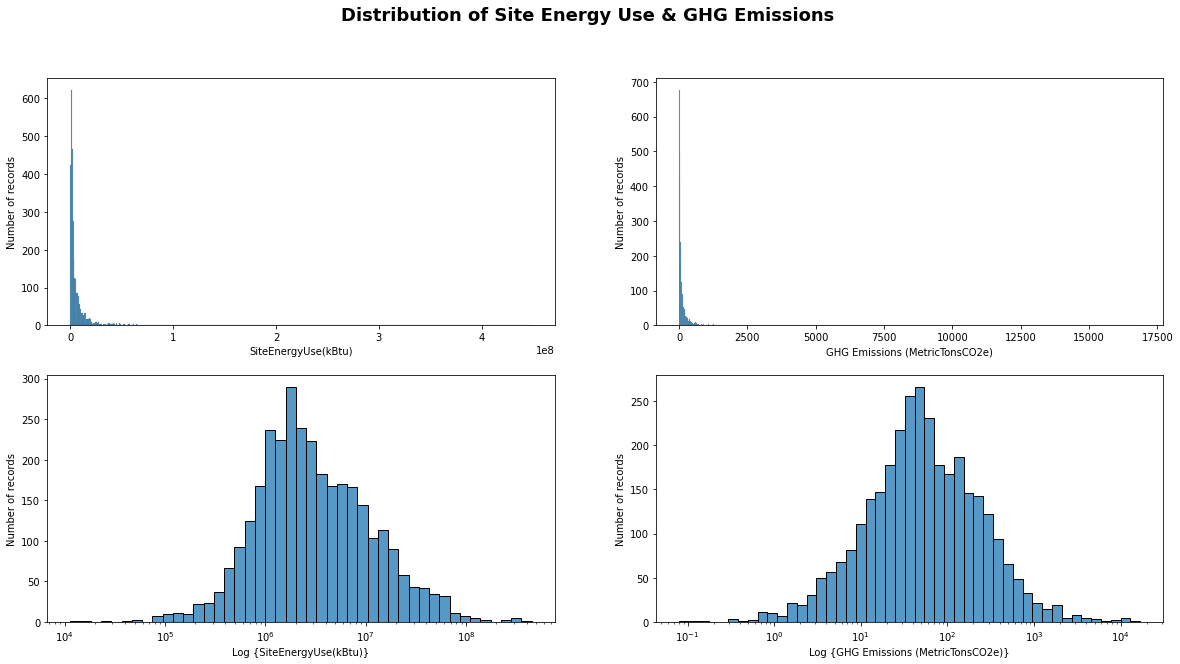

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle("Distribution of Site Energy Use & GHG Emissions", fontsize=18, weight = 'bold')

sns.histplot(data=df_data_non_ener, x='SiteEnergyUse(kBtu)', ax=axes[0,0] ) 
axes[0,0].set_xlabel("SiteEnergyUse(kBtu)")
axes[0,0].set_ylabel("Number of records")

sns.histplot(data=df_data_non_ener, x='SiteEnergyUse(kBtu)', ax=axes[1,0] , log_scale=True) 
axes[1,0].set_xlabel("Log {SiteEnergyUse(kBtu)}")
axes[1,0].set_ylabel("Number of records")

sns.histplot(data=df_data_non_ener, x='GHGEmissions(MetricTonsCO2e)', ax=axes[0,1] ) 
axes[0,1].set_xlabel("GHG Emissions (MetricTonsCO2e)")
axes[0,1].set_ylabel("Number of records")

sns.histplot(data=df_data_non_ener, x='GHGEmissions(MetricTonsCO2e)', ax=axes[1,1] , log_scale=True) 
axes[1,1].set_xlabel("Log {GHG Emissions (MetricTonsCO2e)}")
axes[1,1].set_ylabel("Number of records")

plt.show()

At first, a linear model will be applied on the original targets. As seen above and due to the non-linearity, a logarithmic function will be used to linearize the targets, allowing comparison between a linear and logarithmique scale on such skewed data. Log transformation helps reducing skewness.


In [160]:
df_data_non_ener['logSEU'] = np.log10(df_data_non_ener['SiteEnergyUse(kBtu)'])
df_try = df_data_non_ener.drop(['SiteEnergyUse(kBtu)'], axis=1)
df_try

,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,GHGEmissions(MetricTonsCO2e),Latitude,Longitude,AgeofBuilding,MeanBuildingGFA,MeanFloorGFA,BuildingGFApct,ParkingGFApct,logSEU
0,2015,NonResidential,Hotel,Downtown,1.0,12.0,88434,Hotel,249.43,47.612190,-122.337997,88,88434.0,7369.500000,1.000000,0.000000,6.843944
1,2016,NonResidential,Hotel,Downtown,1.0,12.0,88434,Hotel,249.98,47.612200,-122.337990,89,88434.0,7369.500000,1.000000,0.000000,6.858920
2,2015,NonResidential,Hotel,Downtown,1.0,11.0,103566,Hotel,263.51,47.613106,-122.333358,19,103566.0,9415.090909,0.854547,0.145453,6.921907
3,2016,NonResidential,Hotel,Downtown,1.0,11.0,103566,Hotel,295.86,47.613170,-122.333930,20,103566.0,9415.090909,0.854547,0.145453,6.923655
4,2015,NonResidential,Hotel,Downtown,1.0,41.0,961990,Hotel,2061.48,47.613349,-122.337699,46,961990.0,23463.170732,1.000000,0.000000,7.864099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,2016,Nonresidential COS,Other,Delridge Neighborhoods,1.0,1.0,18261,Other - Recreation,20.33,47.540670,-122.374410,34,18261.0,18261.000000,1.000000,0.000000,5.969454
3169,2016,Nonresidential COS,Other,Downtown,1.0,1.0,16000,Other - Recreation,32.17,47.596250,-122.322830,12,16000.0,16000.000000,1.000000,0.000000,5.977850
3170,2016,Nonresidential COS,Other,Magnolia / Queen Anne,1.0,1.0,13157,Other - Recreation,223.54,47.636440,-122.357840,42,13157.0,13157.000000,1.000000,0.000000,6.760867
3171,2016,Nonresidential COS,Mixed Use Property,Greater Duwamish,1.0,1.0,14101,Other - Recreation,22.11,47.528320,-122.324310,27,14101.0,14101.000000,1.000000,0.000000,5.857013


### LINEAR & NON-LINEAR REGRESSIONS

In order to create a regression model that can relate our different features to the Energy Use or GHG Emissions, a baseline model will be built to get a basis for comparison. Linear regression will then be computed and compared to the baseline to check any improvement in our model.

Step 1: __DATA SELECTION__

In [161]:
X = df_data_non_ener.drop(['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)'], axis=1)
y = df_data_non_ener[['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']]

Step 2: __STANDARDIZATION & CATEGORICAL ENCODING__<br>

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. StandardScaler results in a distribution with a standard deviation equal to 1. <br>
In addition to that, categorical data must be converted to numbers. A one hot encoding is a representation of categorical variables as binary vectors.
It requires that the categorical values be mapped to integer values.
Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1. 

In [162]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

cat_data = list(categorical_features.columns)
num_data = list(numerical_features.columns)
preprocessor = ColumnTransformer(transformers=
                                 [('num', scaler, num_data ),
                                  ('cat', categorical_transformer, cat_data)])

Step 3: __TRAIN-TEST SPLIT EVALUATION__<br>

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.<br>
The objective is to estimate the performance of the machine learning model on new data: data not used to train the model.

In [163]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Step 4: __BASELINE CREATION__<br>

The Dummy Regressor is a kind of Regressor that gives prediction based on simple strategies without paying any attention to the input Data. The sklearn library provides Dummy Regressor which is used to set up a baseline for comparing different regressions. Training the dummy model is similar to training any regular regression model, except for the strategies. The main role of strategy is to predict target values without any influence of the training data.<br> We are here using the strategy "mean" which is the default strategy used by the Dummy Regressor. It always predicts the mean of the training target values.

In [164]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
dummy_pred = dummy_reg.predict(X_test)

To evaluate our regression model, we compute few meaningful prameters to estimate how far our predictions are from the actual data:

MAE is the sum of absolute differences between our target and predicted variables.
MSE measures the average squared difference between the estimated values and the actual value.
RMSE is the standard deviation of the residuals.
R² is the coefficient of determination and evaluates the scatter of the data points around the fitted regression line.



In [165]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def algo_model(y_actual, y_forecast):
    """Return metrics for model evaluation in regression"""
    
    y_actual, y_forecast = np.array(y_actual), np.array(y_forecast)
    
    mse = mean_squared_error(y_actual, y_forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_forecast)
    
    functions = {"Functions":["Root Mean Squared Error (RMSE)",
                              "Mean Absolute Error (MAE)", "Coefficient of determination (R²)"],
                              "Results":[rmse, mae, r2_score(y_actual, y_forecast)]}
    
    df_functions = pd.DataFrame(functions) 
    return df_functions

In [166]:
dummy_metrics = algo_model(y_test['SiteEnergyUse(kBtu)'], dummy_pred).rename(columns={'Results':'Baseline'})
dummy_metrics.index = np.arange(1, len(dummy_metrics)+1)
dummy_metrics

,Functions,Baseline
1,Root Mean Squared Error (RMSE),1.872051e+07
2,Mean Absolute Error (MAE),8.592903e+06
3,Coefficient of determination (R²),-1.552097e-05


__LINEAR REGRESSION - LINEAR SCALE__

In [167]:
start_time0 = time.time()
from sklearn.pipeline import Pipeline

pipe_lin = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

X = df_data_non_ener[num_data + cat_data]

pipe_lin.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred_lin = pipe_lin.predict(X_test)

mae_test0 = mean_absolute_error(y_pred_lin, y_test['SiteEnergyUse(kBtu)'])
r2_test0 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred_lin)
tm0 = time.time() - start_time0
lin_metrics = algo_model(y_test['SiteEnergyUse(kBtu)'], y_pred_lin).rename(columns={'Results':'Linear'})
lin_metrics.index = np.arange(1, len(lin_metrics)+1)
lin_metrics = pd.concat([dummy_metrics, lin_metrics['Linear']], axis=1)
round(lin_metrics, 2)


,Functions,Baseline,Linear
1,Root Mean Squared Error (RMSE),18720512.46,10870869.51
2,Mean Absolute Error (MAE),8592903.43,4534146.80
3,Coefficient of determination (R²),-0.00,0.66


__LINEAR REGRESSION - LOG SCALE__

In [168]:

start_time01 = time.time()

regr = TransformedTargetRegressor(regressor=LinearRegression(), 
                                func=np.log1p, 
                        inverse_func=np.expm1)

pipe_log = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', regr)])

pipe_log.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred_log = pipe_log.predict(X_test)

log_metrics = algo_model(y_test['SiteEnergyUse(kBtu)'], y_pred_log).rename(columns={'Results':'Log'})
log_metrics.index = np.arange(1, len(log_metrics)+1)
log_metrics = pd.concat([lin_metrics, log_metrics['Log']], axis=1)


y_pred_bis = pipe_log.predict(X_test)

mae_test01 = mean_absolute_error(y_pred_bis, y_test['SiteEnergyUse(kBtu)'])
r2_test01 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred_bis)
print("R2 test1: %.2f" % r2_test01)
print('R2 test2: {0:.2f}'.format(pipe_log.score(X_test, y_test['SiteEnergyUse(kBtu)'])))
print("MAE test: %.2f" % mae_test01)
tm01 = time.time() - start_time01
print("Running Time: %s seconds" % (tm01))
round(log_metrics, 2)

R2 test1: -1.18
R2 test2: -1.18
MAE test: 5383728.89
Running Time: 0.07202935218811035 seconds


,Functions,Baseline,Linear,Log
1,Root Mean Squared Error (RMSE),18720512.46,10870869.51,27660324.71
2,Mean Absolute Error (MAE),8592903.43,4534146.80,5383728.89
3,Coefficient of determination (R²),-0.00,0.66,-1.18


In [169]:
# from sklearn.metrics import fbeta_score, make_scorer
# def r2new(y_true, y_pred):
#     return r2_score(np.exp(y_true), np.exp(y_pred))

# r2new_scorer = make_scorer(r2new, greater_is_better=True)

# y_train_log=np.log(y_train['SiteEnergyUse(kBtu)'])
# pipe_lin.fit(X_train,y_train_log)

# y_log_calc=pipe_lin.predict(X_test)

# print("R2: %s"%r2_scorer(y_test, np.exp(y_log_calc)))

__Column log__

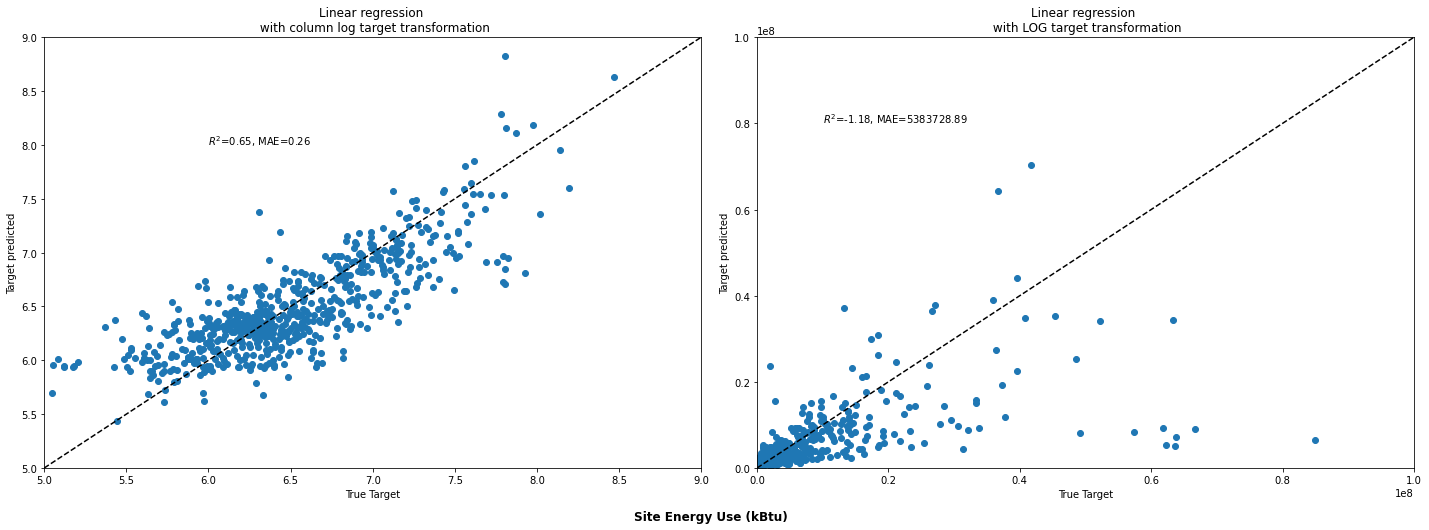

In [170]:

Xtry = df_try.drop(['logSEU', 'GHGEmissions(MetricTonsCO2e)'], axis=1)
ytry = df_try[['logSEU','GHGEmissions(MetricTonsCO2e)']]

Xtry_train, Xtry_test, ytry_train, ytry_test = train_test_split(Xtry, ytry, test_size=0.2, random_state=42)
f, (ax0, ax1) = plt.subplots(1, 2, sharey=False)

# Use linear model
#start_time0 = time.time()
pipe_lin.fit(Xtry_train, ytry_train['logSEU'])

ytry_pred = pipe_lin.predict(Xtry_test)
#tm0 = time.time() - start_time0
# Plot results
ax0.scatter(ytry_test['logSEU'], ytry_pred)
ax0.plot([5, 9], [5, 9], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Linear regression \n with column log target transformation')
r2_test = r2_score(ytry_test['logSEU'], ytry_pred)
MAE_test = mean_absolute_error(ytry_test['logSEU'], ytry_pred)
ax0.text(6, 8, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test, MAE_test))
ax0.set_xlim([5, 9])
ax0.set_ylim([5, 9])

# Transform targets and use same linear model
#start_time01 = time.time()
pipe_log = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', regr)])

regr = TransformedTargetRegressor(regressor=LinearRegression(), 
                                func=np.log1p, 
                        inverse_func=np.expm1)

pipe_log.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = pipe_log.predict(X_test)
tm01 = time.time() - start_time01

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Linear regression \n with LOG target transformation')
r2_test = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(1e7, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (r2_test, MAE_test))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])


__LINEAR MODELS COMPARISON - LINEAR & LOG SCALE__

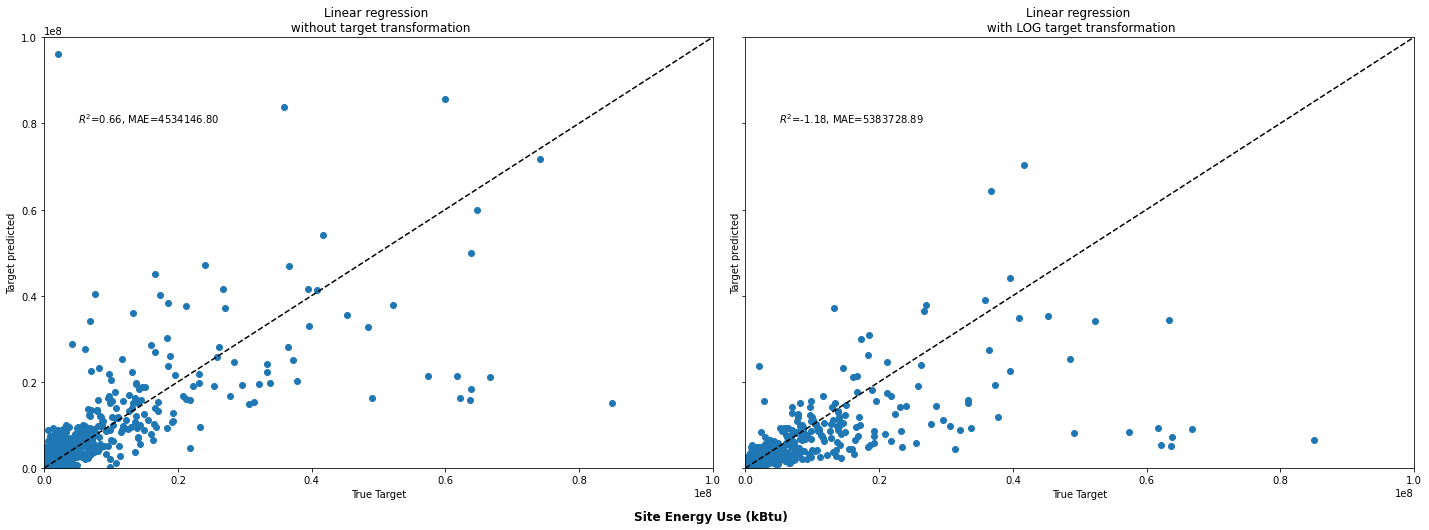

In [171]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use linear model
start_time0 = time.time()
pipe_lin.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = pipe_lin.predict(X_test)
tm0 = time.time() - start_time0
# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Linear regression \n without target transformation')
r2_test0 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test0 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test0, MAE_test0))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same linear model
start_time01 = time.time()
pipe_log = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', regr)])

regr = TransformedTargetRegressor(regressor=LinearRegression(), 
                                func=np.log1p, 
                        inverse_func=np.expm1)

pipe_log.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = pipe_log.predict(X_test)
tm01 = time.time() - start_time01

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Linear regression \n with LOG target transformation')
r2_test01 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test01 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (r2_test01, MAE_test01))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])


### REGRESSION OPTIMIZATION: COMPARISON BETWEEN LINEAR AND LOG SCALE

__LINEAR REGRESSION COMPARISON GRIDSEARCHCV__

Best parameters lin scale: {'regressor__fit_intercept': True, 'regressor__normalize': True}
Best parameters log scale : {'regressor__fit_intercept': False, 'regressor__normalize': True}


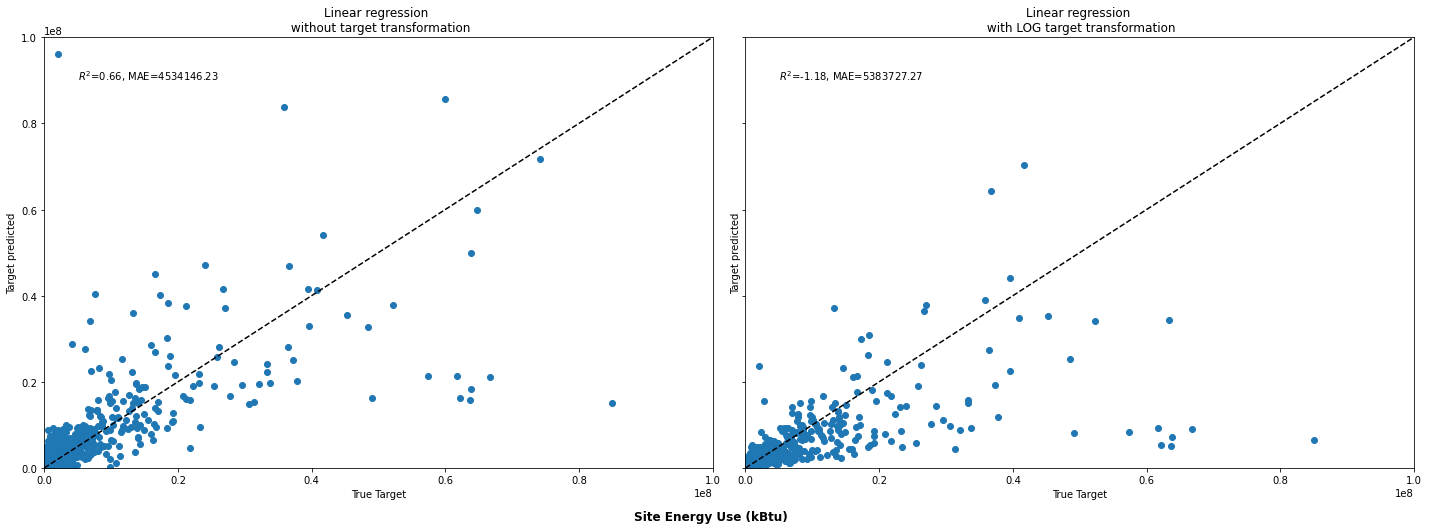

In [172]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use linear model
start_time1 = time.time()
params = {"regressor__fit_intercept": [True, False], # Whether to calculate the intercept for this model
          "regressor__normalize": [True, False]}

grid_cv = GridSearchCV(pipe_lin, 
                       param_grid=params, # Dictionary with parameters names
                       cv=5, # Determines the cross-validation splitting strategy
                       scoring=('r2','neg_mean_absolute_error'), # Strategy to evaluate the performance of the cross-validated model on the test set
                       return_train_score = True, # If False, the cv_results_ attribute will not include training scores
                       refit='neg_mean_absolute_error', # Refit an estimator using the best found hyperparameters 
                       n_jobs = -1) # Number of jobs to run in parallel, all CPUs are used (-1)

grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = grid_cv.predict(X_test)
tm1 = time.time() - start_time1

# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Linear regression \n without target transformation')
r2_test1 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test1 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test1, MAE_test1))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same linear model
start_time11 = time.time()

log_grid_cv = Pipeline([('preprocessor', preprocessor),
                       ('grid_lin', GridSearchCV(
                                                TransformedTargetRegressor(
                                                regressor=LinearRegression(), 
                                                func=np.log1p, 
                                                inverse_func=np.expm1),
                            param_grid=params,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            return_train_score = True, # GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit().
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])
log_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = log_grid_cv.predict(X_test)
tm11 = time.time() - start_time11

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Linear regression \n with LOG target transformation')
r2_test11 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test11 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test11, MAE_test11))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cv.best_params_)
print('Best parameters log scale : {}'.format(log_grid_cv.named_steps['grid_lin'].best_params_))

__LASSO LINEAR & LOG SCALE COMPARISON__<br>

Lasso regression, or the Least Absolute Shrinkage and Selection Operator, is also a modification of linear regression. In Lasso, the loss function is modified to minimize the complexity of the model by limiting the sum of the absolute values of the model coefficients (also called the l1-norm).

Best parameters lin scale: {'regressor__alpha': 1.0, 'regressor__max_iter': 10}
Best parameters log scale : {'regressor__alpha': 1.0, 'regressor__max_iter': 10}


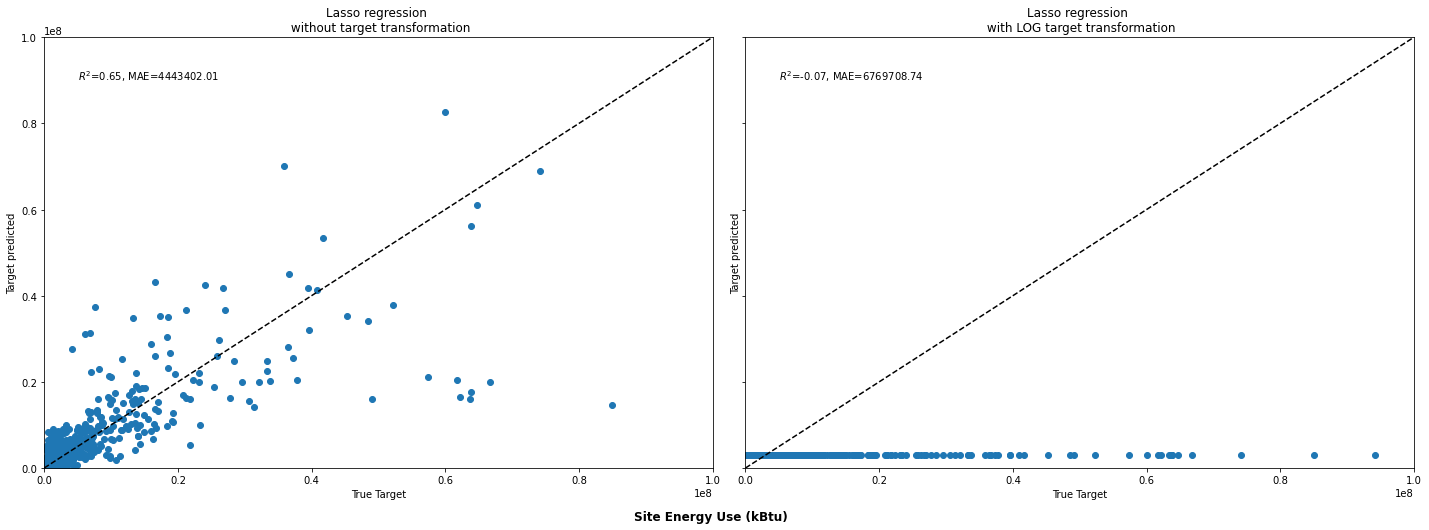

In [173]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Lasso model
start_time2 = time.time()
pipe_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Lasso())])

params_lasso = {"regressor__alpha": np.logspace(-4, 0, num=5), # Constant that multiplies the L1 term (default=1)
               "regressor__max_iter": [10, 50, 100, 1000]} # maximum number of iterations.

lasso_grid_cv = GridSearchCV(pipe_lasso, 
                       param_grid=params_lasso, # Dictionary with parameters names
                       cv=5, # Determines the cross-validation splitting strategy
                       scoring=('r2','neg_mean_absolute_error'), # Strategy to evaluate the performance of the cross-validated model on the test set
                       return_train_score = True, # If False, the cv_results_ attribute will not include training scores
                       refit='neg_mean_absolute_error', #Refit an estimator using the best found parameters on the whole dataset
                       n_jobs = -1) # Number of jobs to run in parallel

lasso_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = lasso_grid_cv.predict(X_test)
tm2 = time.time() - start_time2

# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Lasso regression \n without target transformation')
r2_test2 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test2 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f' % (r2_test2, MAE_test2))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same Lasso model
start_time21 = time.time()

lasso_grid_cvlog = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_lasso', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=Lasso(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_lasso,
                            cv=5,
                            scoring=('r2', 'neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

lasso_grid_cvlog.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = lasso_grid_cvlog.predict(X_test)
tm21 = time.time() - start_time21
ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Lasso regression \n with LOG target transformation')
r2_test21 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test21 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f' % (
   r2_test21, MAE_test21))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', lasso_grid_cv.best_params_)
print('Best parameters log scale : {}'.format(lasso_grid_cvlog.named_steps['grid_lasso'].best_params_))

__RIDGE LINEAR & LOG SCALE__<br>

Ridge regression is an extension of linear regression where the loss function is modified to minimize the complexity of the model. This modification is done by adding a penalty parameter that is equivalent to the square of the magnitude of the coefficients.

Best parameters lin scale: {'regressor__alpha': 10.0, 'regressor__max_iter': 50}
Best parameters log scale : {'regressor__alpha': 0.0001, 'regressor__max_iter': 50}


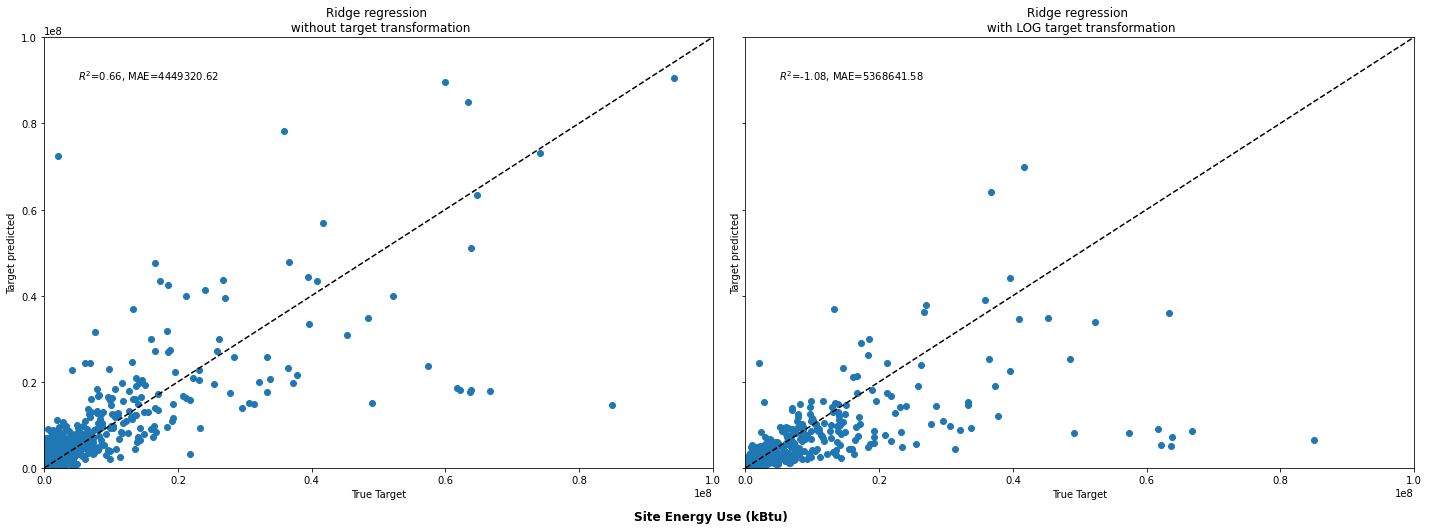

In [174]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Ridge model
start_time3 = time.time()
pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Ridge())])

params_ridge = {"regressor__alpha": np.logspace(-4, 1, num=6), # Regularization strength; must be a positive float (default=1)
                "regressor__max_iter": [10, 50, 100, 1000]} # Max number of iterations
             

grid_ridge = GridSearchCV(pipe_ridge, param_grid=params_ridge, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)

grid_ridge.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = grid_ridge.predict(X_test)
tm3 = time.time() - start_time3

# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
r2_test3 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test3 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test3, MAE_test3))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same Ridge model
start_time31 = time.time()

ridge_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_ridge', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=Ridge(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_ridge,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

ridge_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = ridge_grid_cv.predict(X_test)

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with LOG target transformation')
r2_test31 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test31 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f' % (
   r2_test31, MAE_test31 ))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])
tm31 = time.time() - start_time31

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_ridge.best_params_)
print('Best parameters log scale : {}'.format(ridge_grid_cv.named_steps['grid_ridge'].best_params_))

__ELASTICNET LINEAR & LOG SCALE__<br>

ElasticNet combines the properties of both Ridge and Lasso regression. It works by penalizing the model using both the l2-norm and the l1-norm.

Best parameters lin scale: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.95, 'regressor__max_iter': 10}
Best parameters log scale : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 0.1, 'regressor__max_iter': 10}


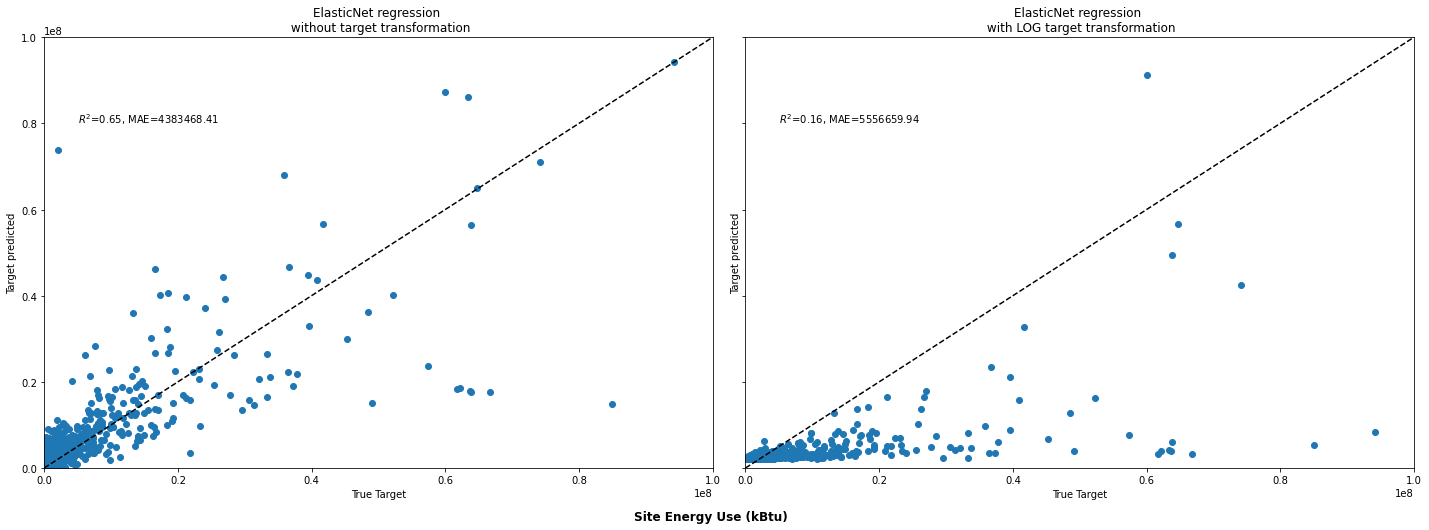

In [175]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use ElasticNet model
start_time4 = time.time()
pipe_eNet = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', ElasticNet())])

params_eNet = {"regressor__alpha": np.logspace(-4, 0, num=5), # Constant that multiplies the penalty terms. Defaults to 1.0
                                                  # alpha=0 the penalty function reduces to the L1 (ridge) term
                                                  # alpha=1, we get the L2 (lasso) term.
              "regressor__l1_ratio": [.001, .01, .1, .5, .7, .9, .95, .99, 1], # The ElasticNet mixing parameter,
                                                                    # with 0 <= l1_ratio <= 1. 
                                                                    # For l1_ratio = 0 the penalty is an L2 penalty.
                                                                    # For l1_ratio = 1 it is an L1 penalty. 
                                                                    # For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
              "regressor__max_iter": [10, 50, 100, 1000, 10000]} # The maximum number of iterations (default = 1000)
             
grid_cvnet = GridSearchCV(pipe_eNet, 
                          param_grid=params_eNet, 
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvnet.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = grid_cvnet.predict(X_test)
tm4 = time.time() - start_time4

# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('ElasticNet regression \n without target transformation')
r2_test4 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test4 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test4, MAE_test4 ))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same ElasticNet model
start_time41 = time.time()

eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_eNet', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=ElasticNet(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_eNet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])


eNet_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = eNet_grid_cv.predict(X_test)
tm41 = time.time() - start_time41

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('ElasticNet regression \n with LOG target transformation')
r2_test41 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test41 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (
   r2_test41 , MAE_test41 ))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvnet.best_params_)
print('Best parameters log scale : {}'.format(eNet_grid_cv.named_steps['grid_eNet'].best_params_))

__KNN LINEAR & LOG SCALE__<br>

KNN regression is a non-parametric method that, in an intuitive manner, approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood.

Best parameters lin scale: {'regressor__n_neighbors': 3}
Best parameters log scale : {'regressor__n_neighbors': 3}


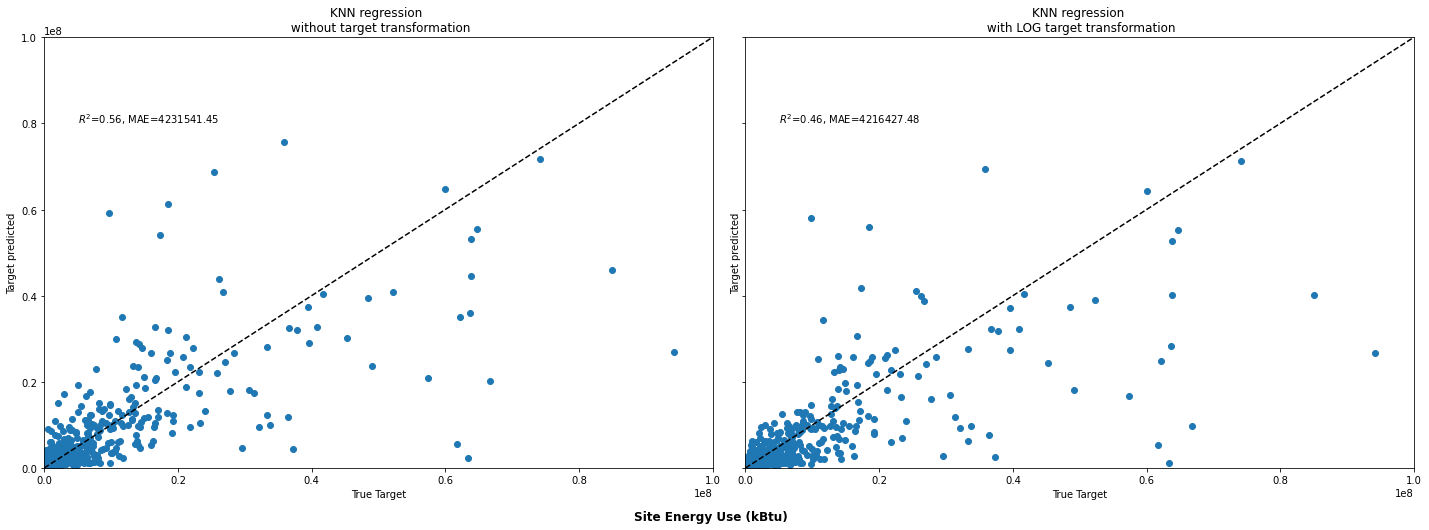

In [176]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use KNN model
start_time5 = time.time()
pipe_knn = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', KNeighborsRegressor())])

params_knn = {'regressor__n_neighbors':[3, 5, 7, 9, 11, 13, 15, 55]}

knn_grid_cv = GridSearchCV(
                    pipe_knn, # pipe with KNN regressor
                    params_knn,     # hyperparameters to test
                    cv=5,           # nombre of cross validation folds
                    scoring=('r2','neg_mean_absolute_error'),   # scoring to optimize
                    return_train_score = True,
                    refit='neg_mean_absolute_error',
                    n_jobs = -1)

knn_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = knn_grid_cv.predict(X_test)
tm5 = time.time() - start_time5

# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('KNN regression \n without target transformation')
r2_test5 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test5 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test5, MAE_test5))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets in Log and use same KNN model
start_time51 = time.time()

knn_grid_cvlog = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_knn', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=KNeighborsRegressor(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_knn,
                            cv=5,
                            scoring= 'neg_mean_absolute_error',
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

knn_grid_cvlog.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = knn_grid_cvlog.predict(X_test)
tm51 = time.time() - start_time51

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('KNN regression \n with LOG target transformation')
r2_test51 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test51 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test51, MAE_test51))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', knn_grid_cv.best_params_)
print('Best parameters log scale : {}'.format(knn_grid_cvlog.named_steps['grid_knn'].best_params_))

__SVM LINEAR & LOG COMPARISON__<br>

Support Vector Regression is a supervised learning algorithm that is used to predict discrete values. Support Vector Regression uses the same principle as the SVMs. The basic idea behind SVR is to find the best fit line. In SVR, the best fit line is the hyperplane that has the maximum number of points.

Best parameters lin scale: {'regressor__C': 0.1, 'regressor__epsilon': 0.1, 'regressor__loss': 'squared_epsilon_insensitive', 'regressor__max_iter': 100}
Best parameters log scale : {'regressor__C': 1, 'regressor__epsilon': 1, 'regressor__loss': 'squared_epsilon_insensitive', 'regressor__max_iter': 2000}


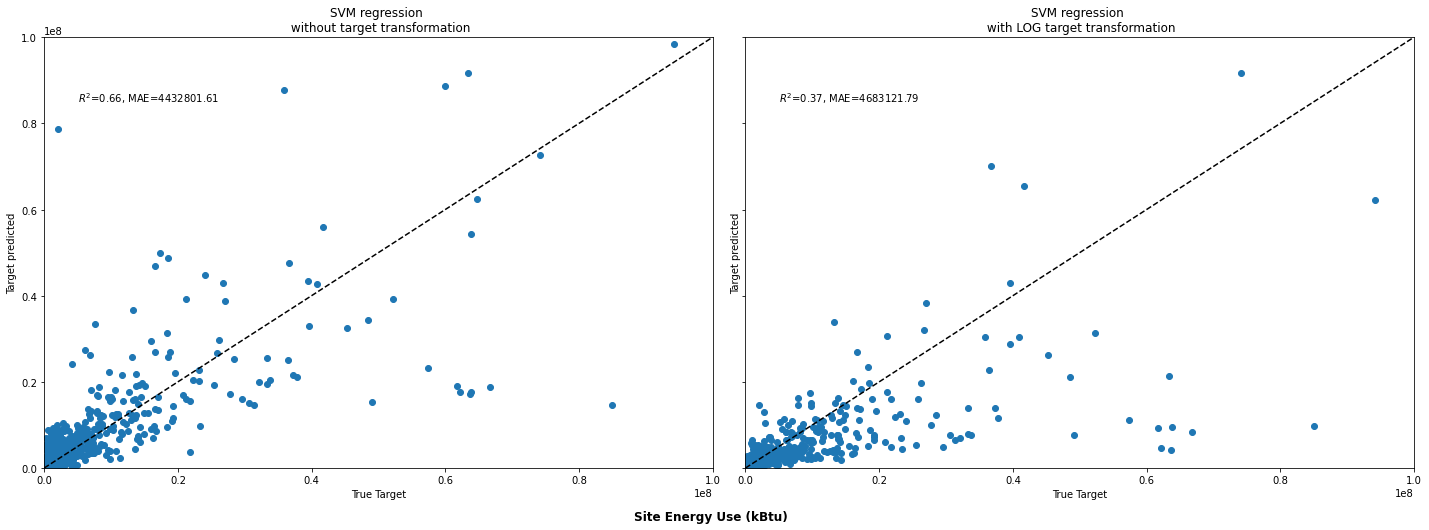

In [177]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use SVM model
start_time6 = time.time()
pipe_svr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearSVR())])

params_svr = {'regressor__epsilon' : [0.1, 1, 0.01 ], # Epsilon parameter in the epsilon-insensitive loss function (default=0)
             'regressor__C' : [0.1, 1, 0.01], # Regularization parameter. The strength of the regularization is inversely proportional to C.
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"], # Specifies the loss function 
             'regressor__max_iter': [10, 100, 1000, 2000]} # The maximum number of iterations to be run (default=1000)

grid_cvsvr = GridSearchCV(pipe_svr, 
                          param_grid=params_svr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvsvr.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = grid_cvsvr.predict(X_test)
tm6 = time.time() - start_time6

# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('SVM regression \n without target transformation')
r2_test6 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test6 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 85e6, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test6, MAE_test6))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same SVM model
start_time61 = time.time()

svr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_svr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearSVR(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_svr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

svr_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = svr_grid_cv.predict(X_test)
tm61 = time.time() - start_time61

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('SVM regression \n with LOG target transformation')
r2_test61 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test61 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 85e6, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test61, MAE_test61))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvsvr.best_params_)
print('Best parameters log scale : {}'.format(svr_grid_cv.named_steps['grid_svr'].best_params_))

__RANDOMFOREST LINEAR & LOG SCALE__<br>

Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression. Ensemble learning method is a technique that combines predictions from multiple machine learning algorithms to make a more accurate prediction than a single model.<br> A Random Forest operates by constructing several decision trees during training time and outputting the mean of the classes as the prediction of all the trees.

Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best parameters log scale : {'regressor__bootstrap': False, 'regressor__max_depth': 100, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


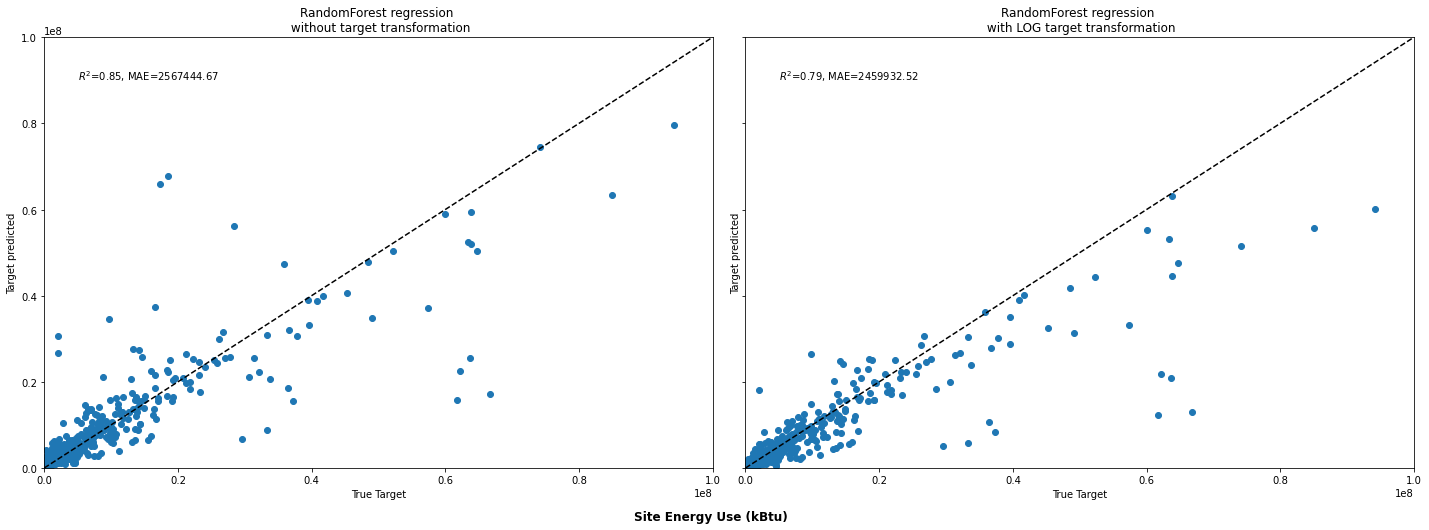

In [178]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use RandomForest model
start_time7 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

params_rfr = {'regressor__max_features' : ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50, 100], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)


grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvrfr.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = grid_cvrfr.predict(X_test)
tm7 = time.time() - start_time7

# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('RandomForest regression \n without target transformation')
r2_test7 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test7 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test7, MAE_test7))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same RandomForest model
start_time71 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

grid_cvrfr_log = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_rfr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

grid_cvrfr_log.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = grid_cvrfr_log.predict(X_test)
tm71 = time.time() - start_time71

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('RandomForest regression \n with LOG target transformation')
r2_test71 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test71 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test71, MAE_test71))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvrfr.best_params_)
print('Best parameters log scale : {}'.format(grid_cvrfr_log.named_steps['grid_rfr'].best_params_))

__XGBOOST LINEAR & LOG SCALE COMPARISON__

Best parameters lin scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}
Best parameters log scale : {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}


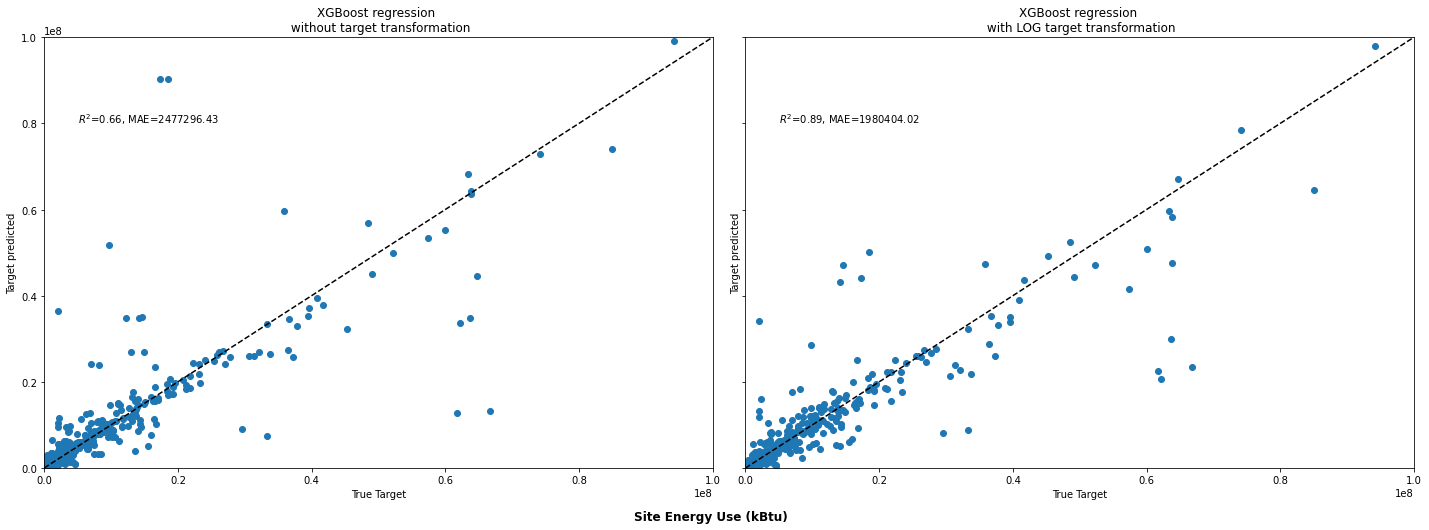

In [179]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time8 = time.time()
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

params_xgb = {'regressor__n_estimators': [10, 1000, 1], # Number of trees in XGBoost (default=100)
             'regressor__min_child_weight' : [1.0, 10.0, 1.0], # Minimum sum of instance weight needed in a child (default=1)
             'regressor__max_depth': [6, 20, 1], # Maximum depth of a tree (default=6). Increasing this value will make
                                                 # the model more complex and more likely to overfit.
             'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3], # Weight factor for the corrections by new trees
                                                                        # to slow down the learning
             'regressor__gamma': [0, 10, 0.1]} # Minimum loss reduction required to make a further partition 
                                               # on a leaf node of the tree (default=0)
                     
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvxgb.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

y_pred = grid_cvxgb.predict(X_test)
tm8 = time.time() - start_time8

# Plot results
ax0.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('XGBoost regression \n without target transformation')
r2_test8 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test8 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax0.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test8, MAE_test8))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same XGBoost model
start_time81 = time.time()

xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_xgb', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(tree_method='hist'), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid = params_xgb,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

xgb_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
y_pred = xgb_grid_cv.predict(X_test)
tm81 = time.time() - start_time81

ax1.scatter(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('XGBoost regression \n with LOG target transformation')
r2_test81 = r2_score(y_test['SiteEnergyUse(kBtu)'], y_pred)
MAE_test81 = mean_absolute_error(y_test['SiteEnergyUse(kBtu)'], y_pred)
ax1.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (r2_test81, MAE_test81))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvxgb.best_params_)
print('Best parameters log scale : {}'.format(xgb_grid_cv.named_steps['grid_xgb'].best_params_))

In [180]:
results = ['R2 lin', 'R2 log', 'MAE lin', "MAE log", 'Running time(s) lin', 'Running time(s) log']
reg_met = {'Linear' : pd.Series([r2_test0, r2_test01, MAE_test0, MAE_test01, tm0, tm01],
                        index = results),
           'Linear grid' : pd.Series([r2_test1, r2_test11, MAE_test1, MAE_test11, tm1, tm11],
                        index = results),
              'Lasso' : pd.Series([r2_test2, r2_test21, MAE_test2, MAE_test21, tm2, tm21],
                        index = results),
              'Ridge' : pd.Series([r2_test3, r2_test31, MAE_test3, MAE_test31, tm3, tm31],
                        index = results),
              'ElasticNet' : pd.Series([r2_test4, r2_test41, MAE_test4, MAE_test41, tm4, tm41],
                        index = results),
              'KNN' : pd.Series([r2_test5, r2_test51, MAE_test5, MAE_test51, tm5, tm51],
                        index = results),
              'SVM' : pd.Series([r2_test6, r2_test61, MAE_test6, MAE_test61, tm6, tm61],
                        index = results),
              'RandomForest' : pd.Series([r2_test7, r2_test71, MAE_test7, MAE_test71, tm7, tm71],
                        index = results),
              'XGBoost' : pd.Series([r2_test8, r2_test81, MAE_test8, MAE_test81, tm8, tm81],
                        index = results)}

# Creates Dataframe df_results_SEU for Site Energy Use

df_results_SEU = pd.DataFrame(reg_met)
index = df_results_SEU.index
index. name = "Metrics"
df_results_SEU.round(2)

,Linear,Linear grid,Lasso,Ridge,ElasticNet,KNN,SVM,RandomForest,XGBoost
Metrics,,,,,,,,,
R2 lin,0.66,0.66,0.65,0.66,0.65,0.56,0.66,0.85,0.66
R2 log,-1.18,-1.18,-0.07,-1.08,0.16,0.46,0.37,0.79,0.89
MAE lin,4534146.80,4534146.23,4443402.01,4449320.62,4383468.41,4231541.45,4432801.61,2567444.67,2477296.43
MAE log,5383728.89,5383727.27,6769708.74,5368641.58,5556659.94,4216427.48,4683121.79,2459932.52,1980404.02
Running time(s) lin,0.05,0.30,3.09,0.94,130.51,5.31,2.95,259.01,808.20
Running time(s) log,0.05,0.22,0.57,0.43,16.72,4.39,1.95,259.28,1449.48


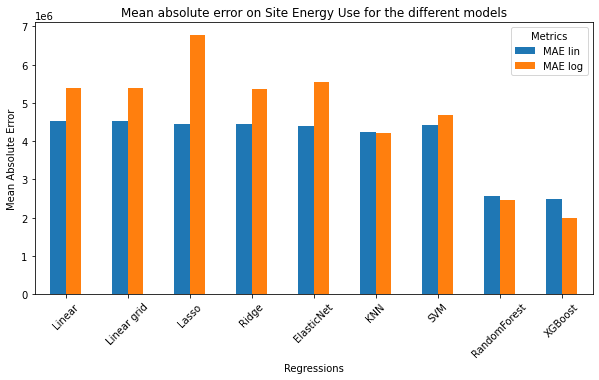

In [181]:
df_SEU = df_results_SEU.T
plt.rcParams["figure.figsize"] = (10, 5)
df_SEU1 = df_SEU[["MAE lin", "MAE log"]].plot( y=["MAE lin", "MAE log"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Mean Absolute Error")
plt.title("Mean absolute error on Site Energy Use for the different models")

plt.show()

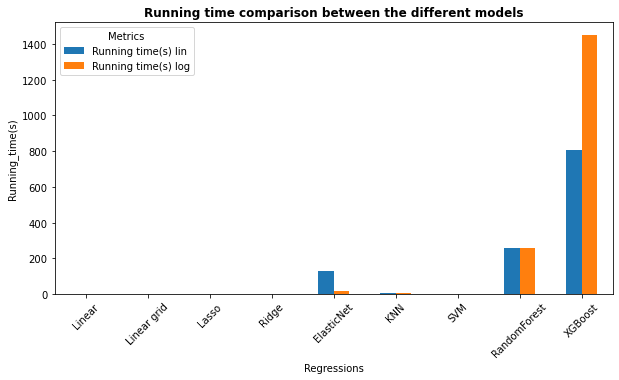

In [182]:
plt.rcParams["figure.figsize"] = (10, 5)
df_SEU22 = df_SEU.plot( y=["Running time(s) lin", "Running time(s) log"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Running_time(s)")
plt.title('Running time comparison between the different models', weight = "bold")
plt.show()

__RANDOMFOREST ON GHG EMISSIONS__

Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best parameters log scale : {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


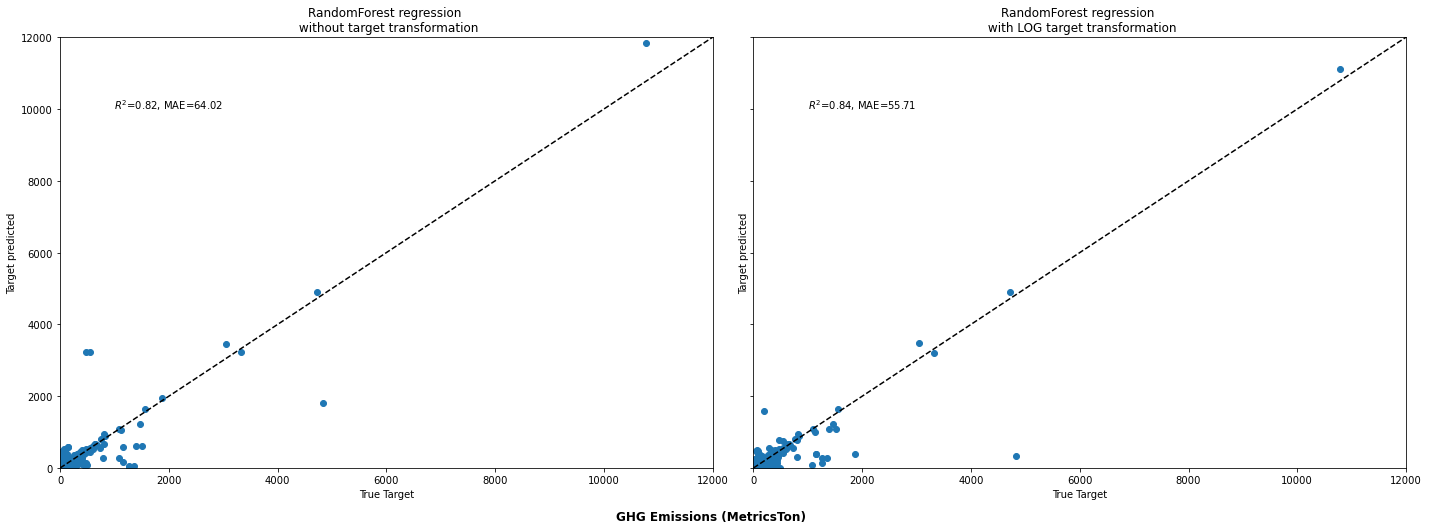

In [183]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use RandomForest model
start_time10 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

params_rfr = {'regressor__max_features' : ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50, 100], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)

grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvrfr.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])

y_pred = grid_cvrfr.predict(X_test)
tm10 = time.time() - start_time10

# Plot results
ax0.scatter(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('RandomForest regression \n without target transformation')
r2_test10 = r2_score(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
MAE_test10 = mean_absolute_error(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test10, MAE_test10))
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# Transform targets and use same RandomForest model
start_time101 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

grid_cvrfr_logE = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_rfrE', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

grid_cvrfr_logE.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
y_pred = grid_cvrfr_logE.predict(X_test)
tm101 = time.time() - start_time101

ax1.scatter(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('RandomForest regression \n with LOG target transformation')
r2_test101 = r2_score(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
MAE_test101 = mean_absolute_error(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
ax1.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test101, MAE_test101))
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHG Emissions (MetricsTon) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvrfr
      
      
      
      
      .best_params_)
print('Best parameters log scale : {}'.format(grid_cvrfr_logE.named_steps['grid_rfrE'].best_params_))

__XGBOOST ON GHG EMISSIONS__

Best parameters lin scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}
Best parameters log scale : {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}


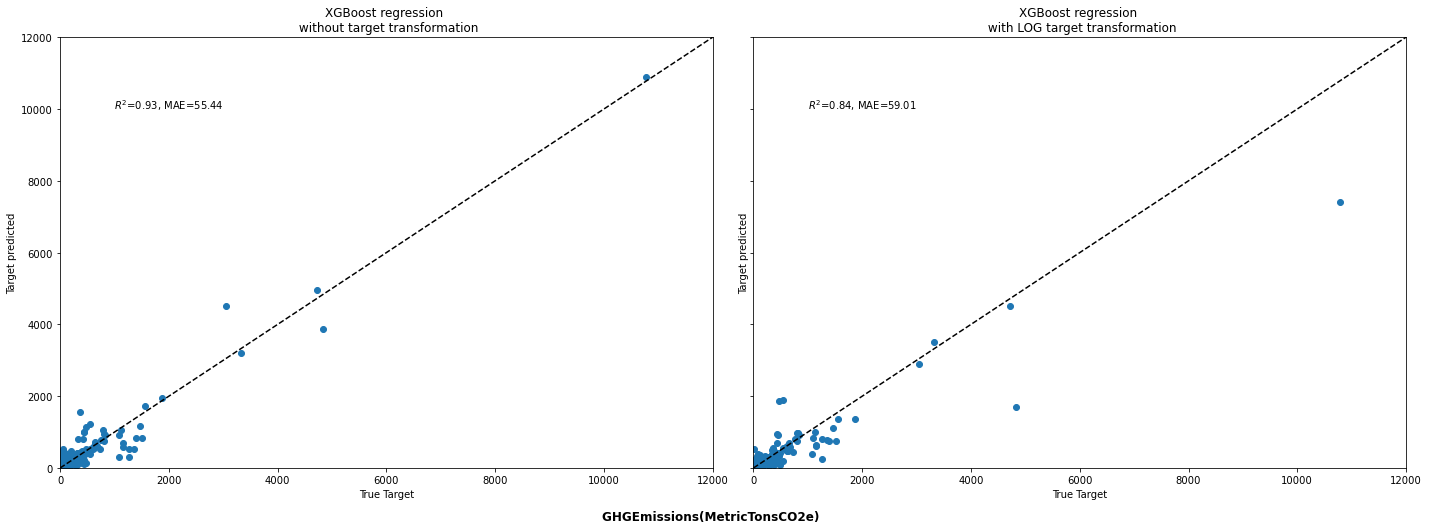

In [184]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time9 = time.time()
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

params_xgb = {'regressor__n_estimators': [10, 1000, 1], # Number of trees in XGBoost (default=100)
             'regressor__min_child_weight' : [1.0, 10.0, 1.0], # Minimum sum of instance weight needed in a child (default=1)
             'regressor__max_depth': [6, 20, 1], # Maximum depth of a tree (default=6). Increasing this value will make
                                                 # the model more complex and more likely to overfit.
             'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3], # Weight factor for the corrections by new trees
                                                                        # to slow down the learning
             'regressor__gamma': [0, 10, 0.1]} # Minimum loss reduction required to make a further partition 
                                               # on a leaf node of the tree (default=0)
                     
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvxgb.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])

y_pred = grid_cvxgb.predict(X_test)
tm9 = time.time() - start_time9

# Plot results
ax0.scatter(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('XGBoost regression \n without target transformation')
r2_test9 = r2_score(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
MAE_test9 = mean_absolute_error(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f' % (r2_test9, MAE_test9))
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# Transform targets and use same XGBoost model
start_time91 = time.time()

xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_xgb', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(tree_method='hist'), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid = params_xgb,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

xgb_grid_cv.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])
y_pred = xgb_grid_cv.predict(X_test)
tm91 = time.time() - start_time91

ax1.scatter(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('XGBoost regression \n with LOG target transformation')
r2_test91 = r2_score(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
MAE_test91 = mean_absolute_error(y_test['GHGEmissions(MetricTonsCO2e)'], y_pred)
ax1.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f' % (r2_test91, MAE_test91))
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvxgb.best_params_)
print('Best parameters log scale : {}'.format(xgb_grid_cv.named_steps['grid_xgb'].best_params_))

__IMPACT OF ENERGYSTARScore__

The Energy Star score of a building is a way to asses the energy usage performance of a building by comparing it with similar buildings. It assigns a number to the building in between 0-100 based on its performance. A score of 0 would mean that the building performs the worst among the similar buildings registered to the program and a score of 100 would mean that the building is the best performer. Similarly, a score of 75 or higher means the building is a top performer and may be eligible for ENERGY STAR certification.

In [185]:
# Data Selection 
df_energystar = df_data.dropna(subset = ["ENERGYSTARScore"])
Xstar = df_energystar.drop(['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)'], axis=1)
ystar = df_energystar[['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']]

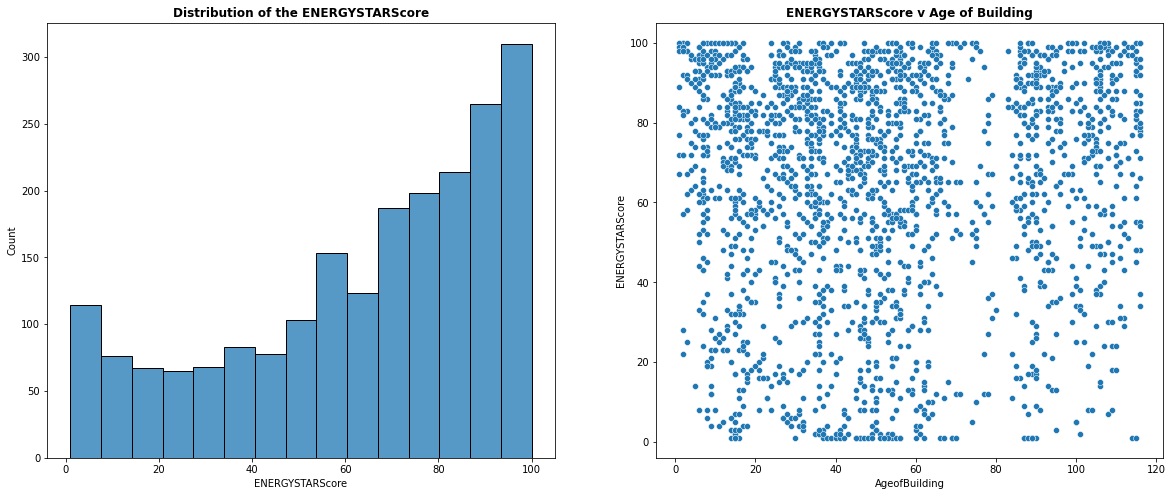

In [186]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data=Xstar, x='ENERGYSTARScore', ax=axes[0])
axes[0].set_title("Distribution of the ENERGYSTARScore", weight = 'bold')

sns.scatterplot(data=df_energystar, y='ENERGYSTARScore', x='AgeofBuilding', ax=axes[1])
axes[1].set_title("ENERGYSTARScore v Age of Building", weight = 'bold')
plt.show()

__RandomForest on SEU with ENERGYSTARScore__

Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 100, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best parameters log scale : {'regressor__bootstrap': True, 'regressor__max_depth': 50, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


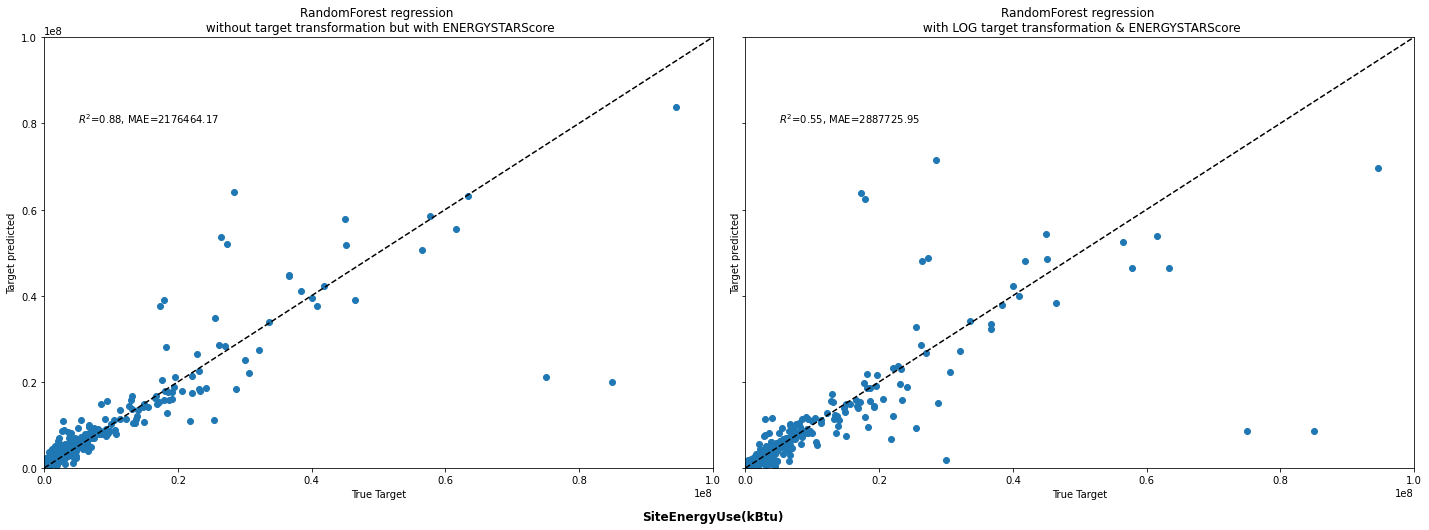

In [197]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

Xstar_train, Xstar_test, ystar_train, ystar_test = train_test_split(Xstar, ystar, test_size=0.2, random_state=42)

# Use RandomForest model
start_time14 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

params_rfr = {'regressor__max_features' : ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50, 100], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)

grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvrfr.fit(Xstar_train, ystar_train['SiteEnergyUse(kBtu)'])

ystar_pred = grid_cvrfr.predict(Xstar_test)
tm14 = time.time() - start_time14

# Plot results
ax0.scatter(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('RandomForest regression \n without target transformation but with ENERGYSTARScore')
r2_test14 = r2_score(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
MAE_test14 = mean_absolute_error(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
ax0.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test14, MAE_test14))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same RandomForest model
start_time141 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

grid_cvrfr_logE = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_rfrE', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

grid_cvrfr_logE.fit(Xstar_train, ystar_train['SiteEnergyUse(kBtu)'])
ystar_pred = grid_cvrfr_logE.predict(Xstar_test)
tm141 = time.time() - start_time141

ax1.scatter(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('RandomForest regression \n with LOG target transformation & ENERGYSTARScore')
r2_test141 = r2_score(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
MAE_test141 = mean_absolute_error(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
ax1.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (r2_test141, MAE_test141))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle('SiteEnergyUse(kBtu)', x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvrfr.best_params_)
print('Best parameters log scale : {}'.format(grid_cvrfr_logE.named_steps['grid_rfrE'].best_params_))

__XGBoost on SEU with ENERGYSTARScore__

Best parameters lin scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}
Best parameters log scale : {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 20, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}


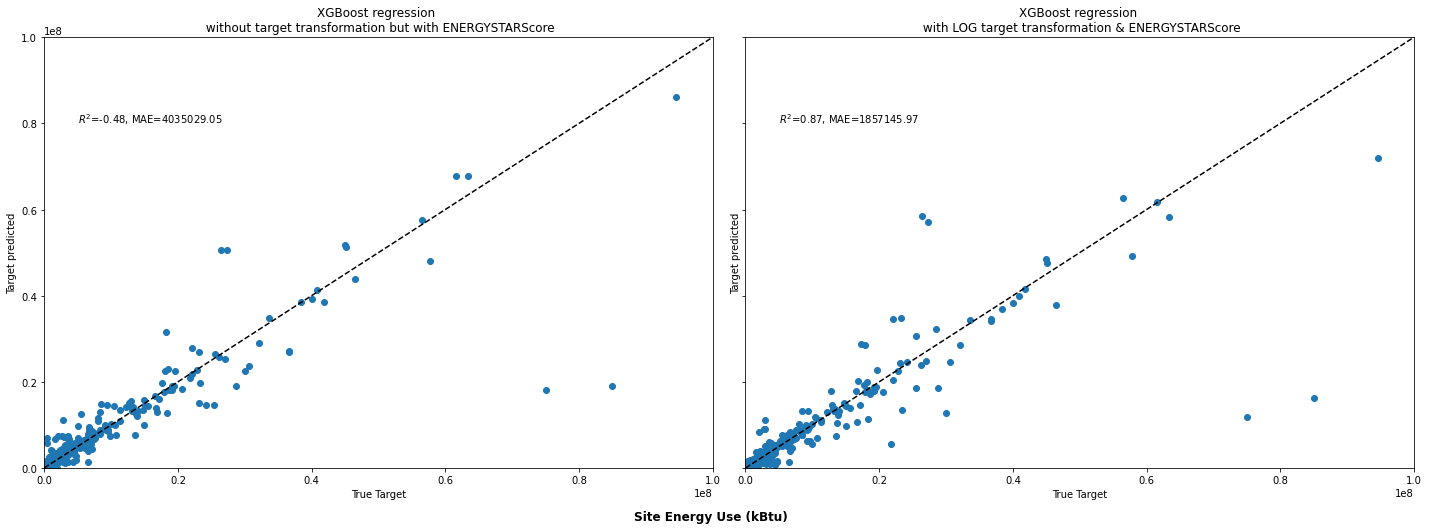

In [199]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time11 = time.time()
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

params_xgb = {'regressor__n_estimators': [10, 1000, 1], # Number of trees in XGBoost (default=100)
             'regressor__min_child_weight' : [1.0, 10.0, 1.0], # Minimum sum of instance weight needed in a child (default=1)
             'regressor__max_depth': [6, 20, 1], # Maximum depth of a tree (default=6). Increasing this value will make
                                                 # the model more complex and more likely to overfit.
             'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3], # Weight factor for the corrections by new trees
                                                                        # to slow down the learning
             'regressor__gamma': [0, 10, 0.1]} # Minimum loss reduction required to make a further partition 
                                               # on a leaf node of the tree (default=0)
                     
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvxgb.fit(Xstar_train, ystar_train['SiteEnergyUse(kBtu)'])

ystar_pred = grid_cvxgb.predict(Xstar_test)
tm11 = time.time() - start_time11

# Plot results
ax0.scatter(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('XGBoost regression \n without target transformation but with ENERGYSTARScore')
r2_test11 = r2_score(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
MAE_test11 = mean_absolute_error(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
ax0.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test11, MAE_test11))
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same XGBoost model
start_time111 = time.time()

xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_xgb', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(tree_method='hist'), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid = params_xgb,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

xgb_grid_cv.fit(Xstar_train, ystar_train['SiteEnergyUse(kBtu)'])
ystar_pred = xgb_grid_cv.predict(Xstar_test)
tm111 = time.time() - start_time111

ax1.scatter(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('XGBoost regression \n with LOG target transformation & ENERGYSTARScore')
r2_test111 = r2_score(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
MAE_test111 = mean_absolute_error(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
ax1.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f' % (r2_test111, MAE_test111))
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvxgb.best_params_)
print('Best parameters log scale : {}'.format(xgb_grid_cv.named_steps['grid_xgb'].best_params_))

__RandomForest on GHG with ENERGYSTARScore__

Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best parameters log scale : {'regressor__bootstrap': False, 'regressor__max_depth': 25, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


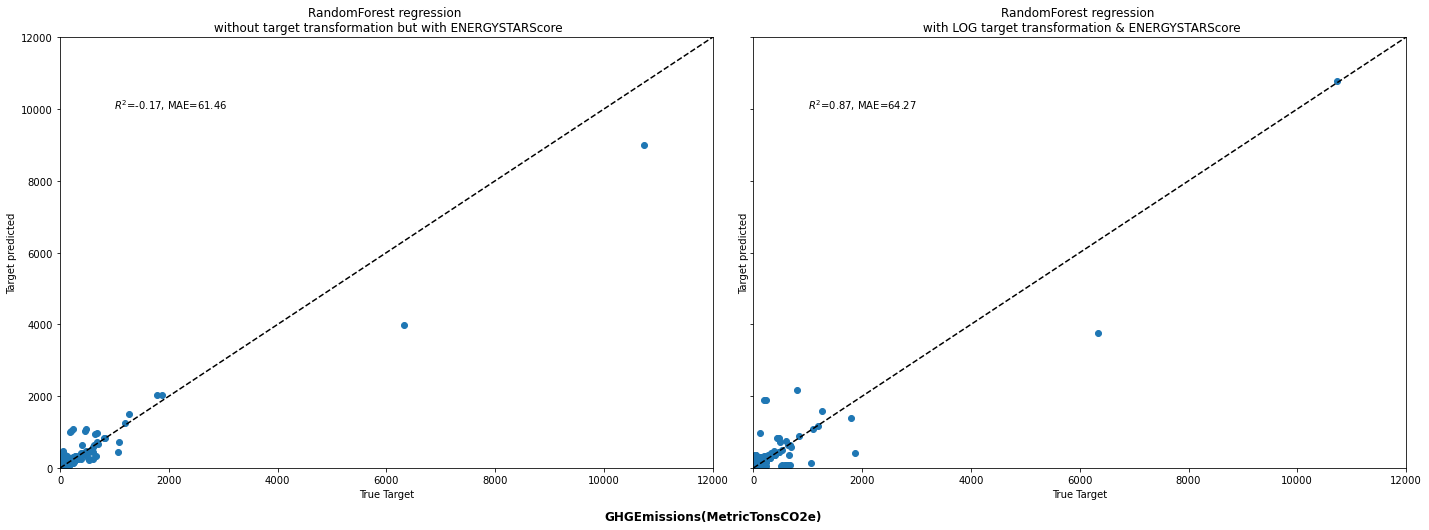

In [193]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use RandomForest model
start_time12 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

params_rfr = {'regressor__max_features' : ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50, 100], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)

grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvrfr.fit(Xstar_train, ystar_train['GHGEmissions(MetricTonsCO2e)'])

ystar_pred = grid_cvrfr.predict(Xstar_test)
tm12 = time.time() - start_time12

# Plot results
ax0.scatter(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('RandomForest regression \n without target transformation but with ENERGYSTARScore')
r2_test12 = r2_score(ystar_test['SiteEnergyUse(kBtu)'], ystar_pred)
MAE_test12 = mean_absolute_error(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test12, MAE_test12))
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# Transform targets and use same RandomForest model
start_time121 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

grid_cvrfr_logE = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_rfrE', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid=params_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

grid_cvrfr_logE.fit(Xstar_train, ystar_train['GHGEmissions(MetricTonsCO2e)'])
ystar_pred = grid_cvrfr_logE.predict(Xstar_test)
tm121 = time.time() - start_time121

ax1.scatter(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('RandomForest regression \n with LOG target transformation & ENERGYSTARScore')
r2_test121 = r2_score(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
MAE_test121 = mean_absolute_error(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
ax1.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f' % (r2_test121, MAE_test121))
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle('GHGEmissions(MetricTonsCO2e)', x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvrfr.best_params_)
print('Best parameters log scale : {}'.format(grid_cvrfr_logE.named_steps['grid_rfrE'].best_params_))

__XGBoost on GHG with ENERGYSTARScore__

Best parameters lin scale: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 20, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}
Best parameters log scale : {'regressor__gamma': 0, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 20, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}


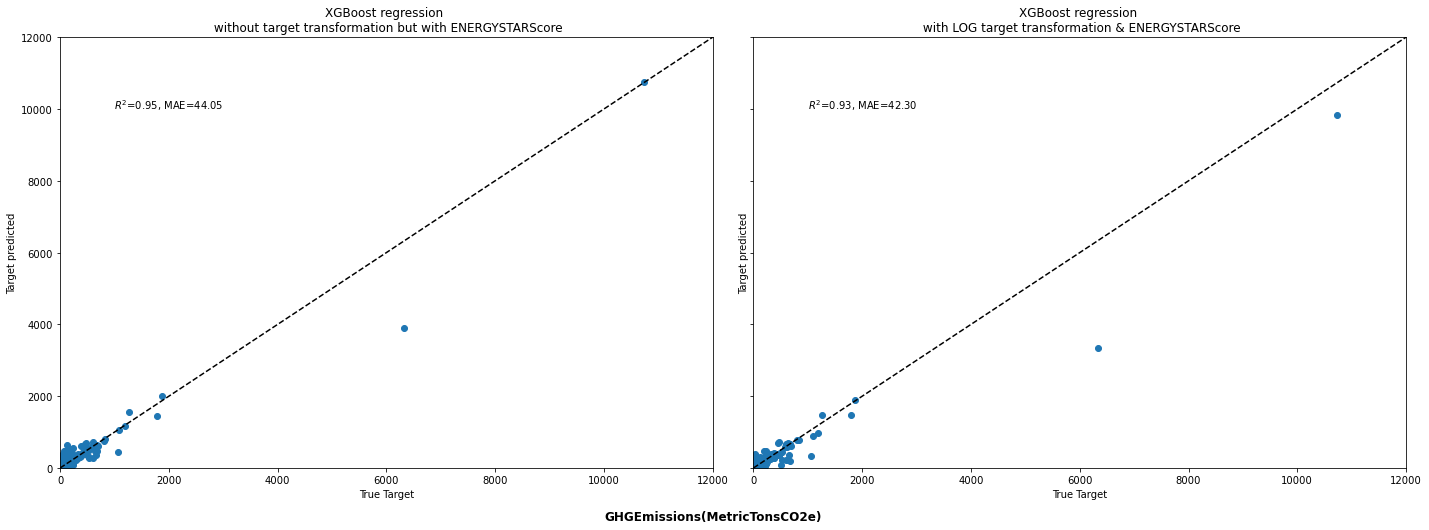

In [202]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time13 = time.time()
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

params_xgb = {'regressor__n_estimators': [10, 1000, 1], # Number of trees in XGBoost (default=100)
             'regressor__min_child_weight' : [1.0, 10.0, 1.0], # Minimum sum of instance weight needed in a child (default=1)
             'regressor__max_depth': [6, 20, 1], # Maximum depth of a tree (default=6). Increasing this value will make
                                                 # the model more complex and more likely to overfit.
             'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3], # Weight factor for the corrections by new trees
                                                                        # to slow down the learning
             'regressor__gamma': [0, 10, 0.1]} # Minimum loss reduction required to make a further partition 
                                               # on a leaf node of the tree (default=0)
                     
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvxgb.fit(Xstar_train, ystar_train['GHGEmissions(MetricTonsCO2e)'])

ystar_pred = grid_cvxgb.predict(Xstar_test)
tm13 = time.time() - start_time13

# Plot results
ax0.scatter(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('XGBoost regression \n without target transformation but with ENERGYSTARScore')
r2_test13 = r2_score(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
MAE_test13 = mean_absolute_error(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_test13, MAE_test13))
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# Transform targets and use same XGBoost model
start_time131 = time.time()

xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_xgb', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(tree_method='hist'), 
                                func=np.log1p, 
                                inverse_func=np.expm1),
                            param_grid = params_xgb,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

xgb_grid_cv.fit(Xstar_train, ystar_train['GHGEmissions(MetricTonsCO2e)'])
ystar_pred = xgb_grid_cv.predict(Xstar_test)
tm131 = time.time() - start_time131

ax1.scatter(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('XGBoost regression \n with LOG target transformation & ENERGYSTARScore')
r2_test131 = r2_score(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
MAE_test131 = mean_absolute_error(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
ax1.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f' % (r2_test131, MAE_test131))
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle('GHGEmissions(MetricTonsCO2e)', x = 1, y=0.005, weight = 'bold')
f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
print('Best parameters lin scale:', grid_cvxgb.best_params_)
print('Best parameters log scale : {}'.format(xgb_grid_cv.named_steps['grid_xgb'].best_params_))

In [200]:
# Site Energy Use
metrics = ['R2 lin', 'R2 log', 'MAE lin', "MAE log", 'Running time(s) lin', 'Running time(s) log']
SEU_data = {'RandomForest' : pd.Series([r2_test7, r2_test71, MAE_test7, MAE_test71, tm7, tm71],
                        index = results),
           'XGBoost' : pd.Series([r2_test8, r2_test81, MAE_test8, MAE_test81, tm8, tm81],
                        index = results),
           'RandomForest ENERGYScore' : pd.Series([r2_test14, r2_test141, MAE_test14, MAE_test141, tm14, tm141],
                        index = results),
            'XGBoost ENERGYScore' : pd.Series([r2_test11, r2_test111, MAE_test11, MAE_test111, tm11, tm111],
                        index = results)}

# Creates Dataframe df_results_SEU for Site Energy Use

df_SEU_stars = pd.DataFrame(SEU_data)
index = df_SEU_stars.index
index. name = "Metrics"
df_SEU_stars.round(2)

,RandomForest,XGBoost,RandomForest ENERGYScore,XGBoost ENERGYScore
Metrics,,,,
R2 lin,0.85,0.66,0.88,-0.48
R2 log,0.79,0.89,0.55,0.87
MAE lin,2567444.67,2477296.43,2176464.17,4035029.05
MAE log,2459932.52,1980404.02,2887725.95,1857145.97
Running time(s) lin,259.01,808.20,180.07,621.22
Running time(s) log,259.28,1449.48,160.01,1687.85


In [203]:
# GHG Emissions
metrics = ['R2 lin', 'R2 log', 'MAE lin', "MAE log", 'Running time(s) lin', 'Running time(s) log']
GHG_data = {'RandomForest' : pd.Series([r2_test10, r2_test101, MAE_test10, MAE_test101, tm10, tm101],
                        index = results),
           'XGBoost' : pd.Series([r2_test9, r2_test91, MAE_test9, MAE_test91, tm9, tm91],
                        index = results),
           'RandomForest ENERGYScore' : pd.Series([r2_test12, r2_test121, MAE_test12, MAE_test121, tm12, tm121],
                        index = results),
            'XGBoost ENERGYScore' : pd.Series([r2_test13, r2_test131, MAE_test13, MAE_test131, tm13, tm131],
                        index = results)}

# Creates Dataframe df_GHG Stars for GHG Emissions

df_GHG_stars = pd.DataFrame(GHG_data)
index = df_GHG_stars.index
index. name = "Metrics"
df_GHG_stars.round(2)

,RandomForest,XGBoost,RandomForest ENERGYScore,XGBoost ENERGYScore
Metrics,,,,
R2 lin,-0.17,0.93,-0.17,0.95
R2 log,0.87,0.84,0.87,0.93
MAE lin,64.33,55.44,61.46,44.05
MAE log,63.64,59.01,64.27,42.30
Running time(s) lin,164.05,662.75,173.95,596.64
Running time(s) log,153.34,2163.47,165.23,2274.88
